In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
import random
%matplotlib inline

In [67]:
args = {'lr':0.01,
        'train epochs':500,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'scaler':RobustScaler(),
        'big epochs':3000,
        'big lr':0.01
        }

# Data Prep

In [68]:
# define layer dictionary to store per layer info
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [69]:
df = pd.read_excel('data_3nm.xlsx')

In [70]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [71]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [72]:
# scale for training
scaler = args['scaler']
scaler.fit(X)
X_scaled = scaler.transform(X)


X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [73]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [74]:
# add noise
X_noisy = add_noise(X, args['noise'])

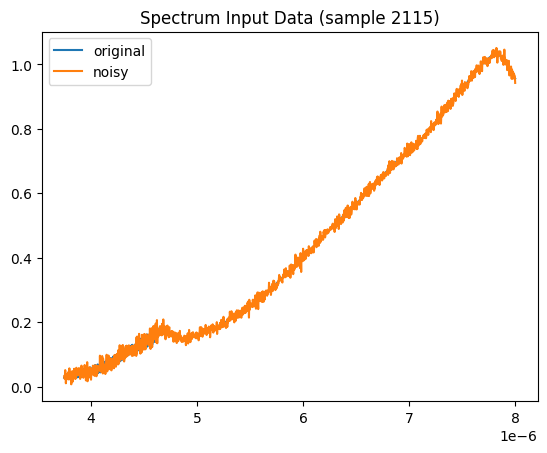

In [75]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [76]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'], random_state=101)

In [78]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[layer['col']].values, dtype=torch.float32).reshape(-1,1)

In [79]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [80]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size):
        super(FeedForward, self).__init__()
        self.lin1 = nn.Linear(input_size, 45)
        self.lin2 = nn.Linear(45, 30)
        self.lin3 = nn.Linear(30, 15)
        self.lin_fin = nn.Linear(15, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = self.lin_fin(x)
        return x

In [81]:
class BigNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(BigNet, self).__init__()
        self.lin1 = nn.Linear(input_size, 45)
        self.lin2 = nn.Linear(45, 30)
        self.lin3 = nn.Linear(30, 15)
        self.lin_fin = nn.Linear(15, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = self.lin_fin(x)
        return x

In [82]:
criterion = args['train criterion']

In [83]:
big_net = BigNet(len(X.columns), len(y.columns))
optimizer = torch.optim.Rprop(big_net.parameters(), lr=args['big lr'])

best_loss = np.inf
best_epoch = 0
train_losses = []


print("Big Net Training")
for epoch in range(args['big epochs']):
    # forward pass
    outputs = big_net(X_train_tensor)

    # get loss
    loss = criterion(outputs, y_train_tensor)

    # update and backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch+1

    if (epoch+1) % int(args['big epochs']/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss}')


Big Net Training
epoch: 300, loss = 4.99196720123291
epoch: 600, loss = 4.539757251739502
epoch: 900, loss = 4.161808013916016
epoch: 1200, loss = 3.8644566535949707
epoch: 1500, loss = 3.753174304962158
epoch: 1800, loss = 3.7022571563720703
epoch: 2100, loss = 3.6827425956726074
epoch: 2400, loss = 3.6754045486450195
epoch: 2700, loss = 3.6708662509918213
epoch: 3000, loss = 3.6633403301239014


In [84]:
X_train_expanded = X_train.copy()
pred = big_net(X_train_tensor)
pred_layers = []
for i in range(pred.size(1)):
    column = pred[:, i]
    X_train_expanded[f'layer {i+1} pred'] = column.detach().numpy().tolist()

In [85]:
X_train_expanded_tensor = torch.tensor(X_train_expanded.values, dtype=torch.float32)

In [86]:
print("Individual Layer Training")
for layer in layers:
    features = X_train_expanded_tensor
    target = layer['y_train']

    # instantiate model
    model = FeedForward(features.size()[1], target.size()[1])

    best_loss = np.inf
    best_epoch = 0
    train_losses = []

    optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

    print(layer['col'])

    for epoch in range(args['train epochs']):
        # forward pass
        outputs = model(features)

        # get loss
        loss = criterion(outputs, target)

        # update and backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch+1

        if (epoch+1) % int(args['train epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

    # store model and losses
    layer['model'] = model
    layer['train losses'] = train_losses

    print(f'best loss: {best_loss} in epoch {best_epoch}\n')    

Individual Layer Training
layer 1
epoch: 50, loss = 7.724135875701904
epoch: 100, loss = 3.7215890884399414
epoch: 150, loss = 3.006967544555664
epoch: 200, loss = 2.7442758083343506
epoch: 250, loss = 2.589083194732666
epoch: 300, loss = 2.4870269298553467
epoch: 350, loss = 2.360102415084839
epoch: 400, loss = 2.299006938934326
epoch: 450, loss = 2.261244297027588
epoch: 500, loss = 2.23734188079834
best loss: 2.23734188079834 in epoch 500

layer 2
epoch: 50, loss = 9.270703315734863
epoch: 100, loss = 8.517221450805664
epoch: 150, loss = 8.065977096557617
epoch: 200, loss = 7.701109886169434
epoch: 250, loss = 7.335310935974121
epoch: 300, loss = 7.004027843475342
epoch: 350, loss = 6.797132968902588
epoch: 400, loss = 6.6641130447387695
epoch: 450, loss = 6.491345405578613
epoch: 500, loss = 6.3322834968566895
best loss: 6.3322834968566895 in epoch 500

layer 3
epoch: 50, loss = 5.8061299324035645
epoch: 100, loss = 4.957160472869873
epoch: 150, loss = 4.486481666564941
epoch: 200,

In [87]:
X_test_expanded = X_test.copy()
big_pred = big_net(X_test_tensor)
pred_layers = []
for i in range(pred.size(1)):
    column = big_pred[:, i]
    X_test_expanded[f'layer {i+1} pred'] = column.detach().numpy().tolist()

In [88]:
X_test_expanded_tensor = torch.tensor(X_test_expanded.values, dtype=torch.float32)

In [89]:
big_losses = []
with torch.no_grad():
    overall_loss = criterion(big_pred, y_test_tensor)
    print("Overall Loss for Big Net: {}".format(overall_loss.item()))

    print("Per Layer Loss for Big Net")
    for layer in layers:
        loss = criterion(big_pred[layer['layer']-1], y_test_tensor[layer['layer']-1])
        print(f'{layer["col"]} loss: {loss.item()}')
        big_losses.append(loss.item())
    

Overall Loss for Big Net: 4.8199052810668945
Per Layer Loss for Big Net
layer 1 loss: 9.570415496826172
layer 2 loss: 4.9573588371276855
layer 3 loss: 3.2578790187835693
layer 4 loss: 4.772702217102051
layer 5 loss: 4.581457138061523
layer 6 loss: 4.1191630363464355
layer 7 loss: 5.498485088348389
layer 8 loss: 6.065662860870361
layer 9 loss: 3.638458251953125
layer 10 loss: 5.666825771331787
layer 11 loss: 4.178955078125


In [90]:
little_losses = []
test_criterion = args['test criterion']
pred_df_little = y_test.copy()

print("Individual Model Test Losses")

for layer in layers:
    pred = layer['model'](X_test_expanded_tensor)
    loss = criterion(pred, layer['y_test'])
    print(f'{layer["col"]} loss: {loss.item()}')
    little_losses.append(loss.item())

Individual Model Test Losses
layer 1 loss: 4.134415149688721
layer 2 loss: 8.688865661621094
layer 3 loss: 5.3896260261535645
layer 4 loss: 5.007874488830566
layer 5 loss: 5.5218610763549805
layer 6 loss: 5.902726650238037
layer 7 loss: 6.100609302520752
layer 8 loss: 4.268294811248779
layer 9 loss: 4.154170989990234
layer 10 loss: 4.068947792053223
layer 11 loss: 1.7570867538452148


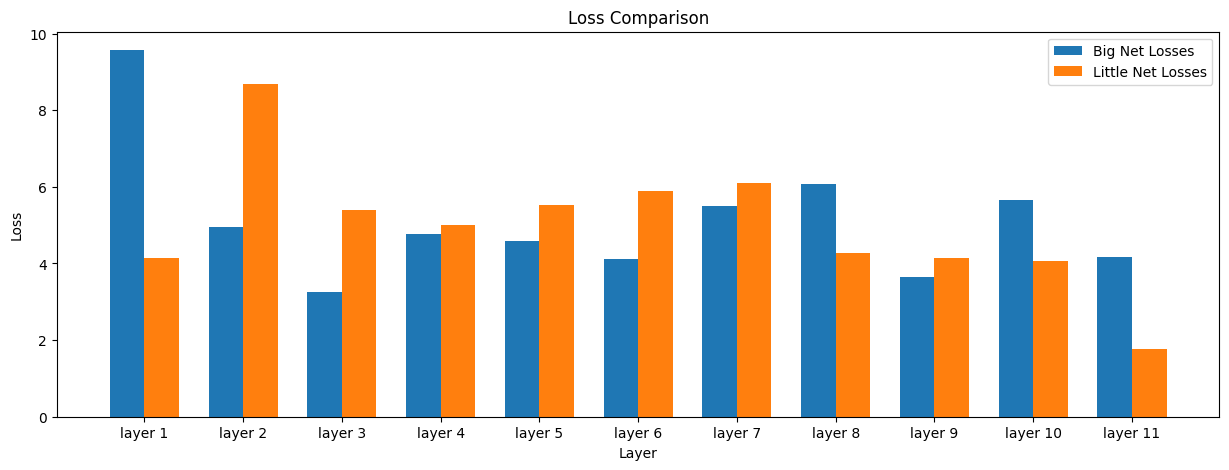

In [91]:
index = np.arange(11)
bar_width = 0.35

fig, ax = plt.subplots(figsize=(15,5))
summer = ax.bar(index, big_losses, bar_width,
                label="Big Net Losses")

winter = ax.bar(index+bar_width, little_losses,
                 bar_width, label="Little Net Losses")

ax.set_xlabel('Layer')
ax.set_ylabel('Loss')
ax.set_title('Loss Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(y.columns)
ax.legend()

plt.show()

In [92]:
def plot_comparison(pred_big, pred_little, actual, sample):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {sample}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred_little, 'go', label='little predicted')
    plt.plot(pred_big, 'ro', label='big predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

In [93]:
actual_df = y_test

pred_df_big = pd.DataFrame(make_predictions(X_test).detach().numpy())
pred_df_big.columns = actual_df.columns

pred_df_little = pred_df_little.iloc[:, 11:]
pred_df_little.columns = actual_df.columns

NameError: name 'make_predictions' is not defined

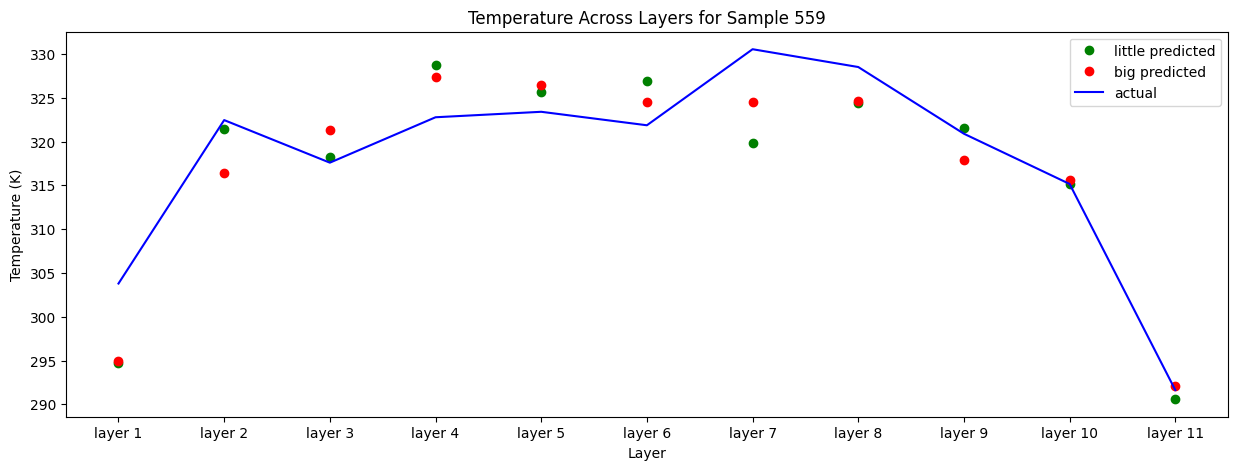

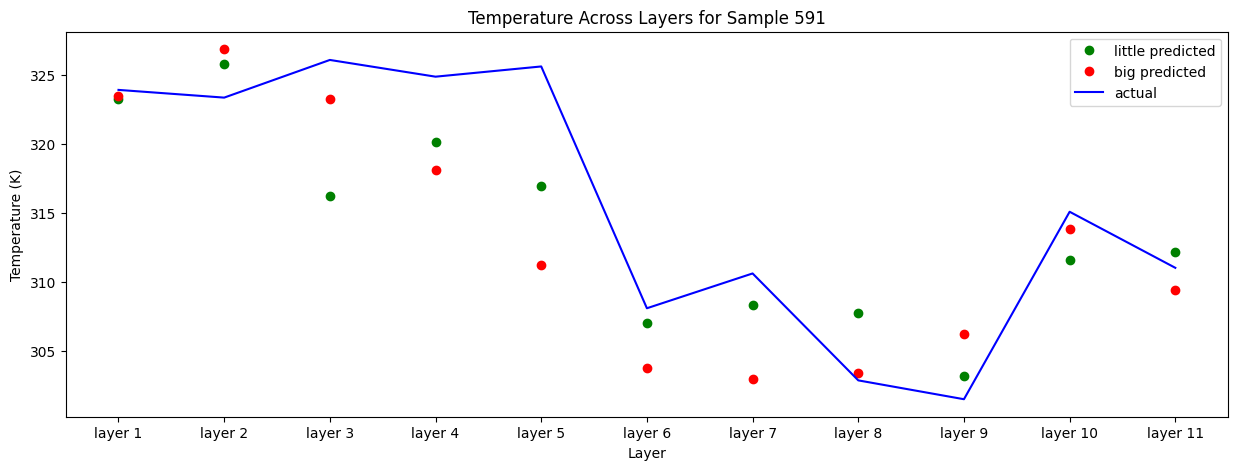

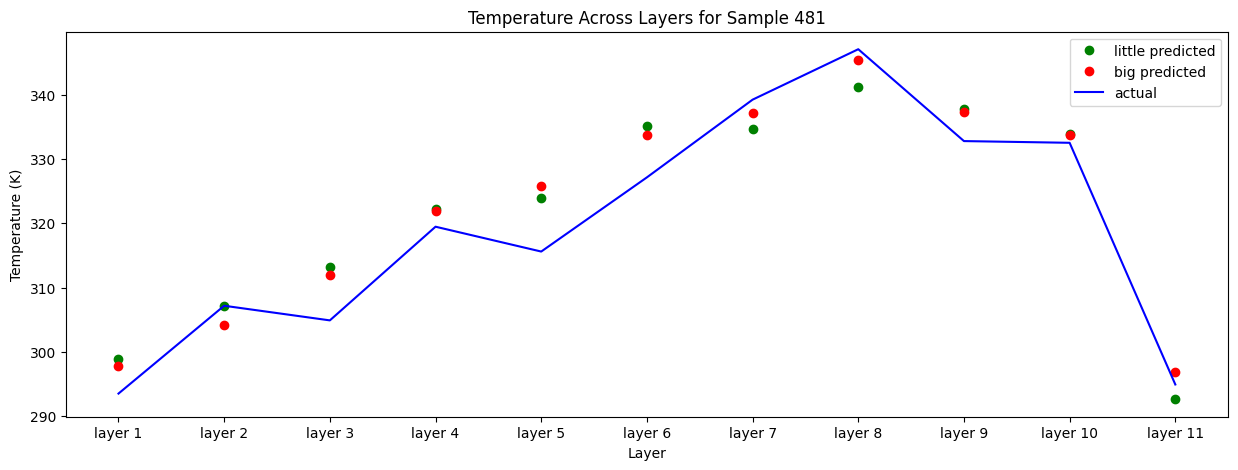

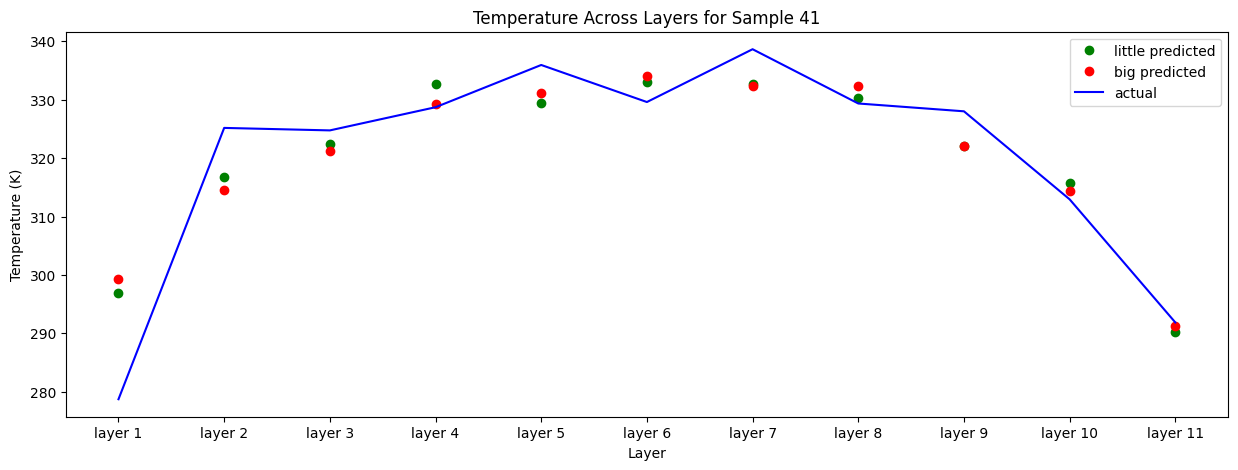

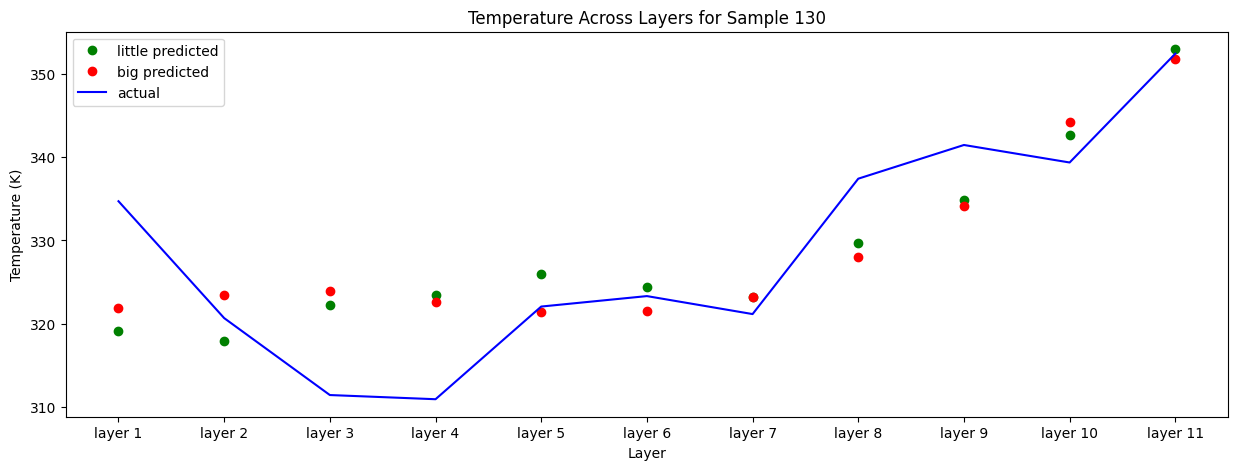

In [ ]:
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    actual = actual_df.iloc[i,:]
    pred_big = pred_df_big.iloc[i,:]
    pred_little = pred_df_little.iloc[i,:]

    plot_comparison(pred_big, pred_little, actual, i)